# Investigation of a simplified model for Uruguay

In [1]:
import pypsa

import matplotlib.pyplot as plt
import pandas as pd

~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


## Read data

In [2]:
hydro_fl = "UY_data/uy_hydro_2013.csv"
wind_fl = "UY_data/uy_wind_2013.csv"

load_fl = "UY_data/uy_load.csv"

In [3]:
hydro_df = pd.read_csv(hydro_fl)
wind_df = pd.read_csv(wind_fl)

load_df = pd.read_csv(load_fl)

### Investigate dynamics of the inputs

In [4]:
wind_df["UY0 1 onwind"].mean()

0.261153036839995

<AxesSubplot:>

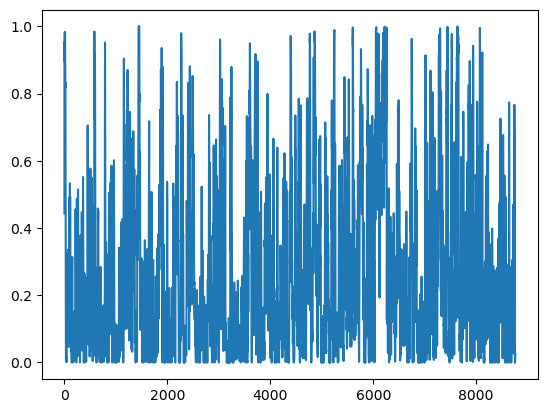

In [5]:
wind_df["UY0 1 onwind"].plot()

<AxesSubplot:>

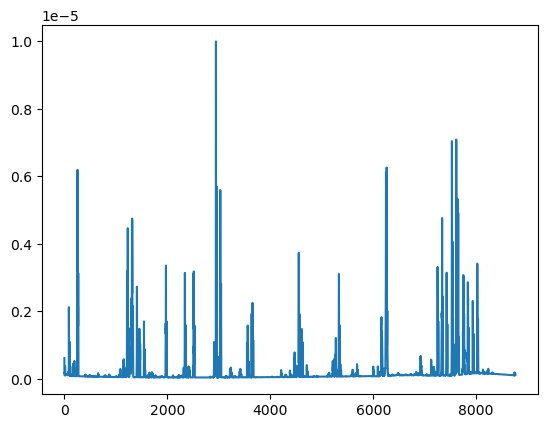

In [6]:
(hydro_df["0"] / (7.838 * 1e9)).plot()

## Build the model

In [7]:
network = pypsa.Network(snapshots = load_df.index)
network.add("Bus", "B1")

network.add("Generator", "Wind",
            carrier = "wind",
            bus="B1",
            capital_cost = 1_000,
            #p_nom_max = 1e9,
            p_max_pu = wind_df["UY0 1 onwind"],
            p_nom_extendable = True)

network.add("Generator", "LoadShedding",
            carrier = "shedding",
            bus="B1",
            capital_cost = 0,
            marginal_cost = 1e8,
            p_nom_extendable = True)

network.add("StorageUnit", "Hydro",
            bus="B1",
            capital_cost = 400_000,
            max_hours = 6,
            p_max_pu=1.0,  # dispatch
            p_min_pu=0.0,  # store

            p_nom = 1e5,
            inflow = hydro_df["0"],       

            p_nom_extendable = True,
            efficiency_dispatch=0.9,
            efficiency_store=0.0,
            cyclic_state_of_charge=True)

network.add("Load", "L1",
            bus="B1",
            p_set=load_df["0"])

~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' 

In [8]:
network.optimize()

~/opt/miniconda3/envs/pypsa-earth-old3/lib/python3.10/site-packages/pypsa/optimization/constraints.py:516: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 93.15it/s]
INFO:linopy.io: Writing time: 0.56s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/linopy-problem-3f36dnn_.lp
 --output /var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/linopy-solve-kljgzvci.sol
Reading problem data from '/var/folders/qn/vpndfm21795ckkq89np1ckp40000gn/T/linopy-problem-3f36dnn_.lp'...
105123 rows, 43804 columns, 183560 non-zeros
551497 lines were read
GLPK Simplex Optimizer 5.0
105123 rows, 43804 columns, 183560 non-zeros
Preprocessing...
521

('ok', 'optimal')

## Investigation of optimisation outputs

In [9]:
network.statistics()

Capacity Factor  Capital Expenditure   Curtailment  \
            carrier                                                        
Generator   shedding              NaN         0.000000e+00  0.000000e+00   
            wind             0.195424         1.969470e+06  1.133994e+06   
Load        -                     NaN                  NaN           NaN   
StorageUnit -                0.003669         1.548612e+11  0.000000e+00   

                          Dispatch  Installed Capacity  Market Value  \
            carrier                                                    
Generator   shedding  0.000000e+00                 0.0           NaN   
            wind      3.371566e+06                 0.0      0.584142   
Load        -        -1.581497e+07                 NaN   6505.377358   
StorageUnit -         1.244341e+07            100000.0  -8268.180607   

                      Operational Expenditure  Optimal Capacity       Revenue  \
            carrier                                                             
Generator   shedding                      0.0              0.00  0.000000e+00   
            wind                          0.0           1969.47  1.969472e+06   
Load        -                             NaN               NaN -1.028824e+11   
StorageUnit -                             0.0         387153.00 -1.028843e+11   

                            Supply    Withdrawal  
            carrier                               
Generator   shedding  0.000000e+00  0.000000e+00  
            wind      3.371566e+06  0.000000e+00  
Load        -         0.000000e+00 -1.581497e+07  
StorageUnit -         1.244341e+07  0.000000e+00

<AxesSubplot:xlabel='snapshot'>

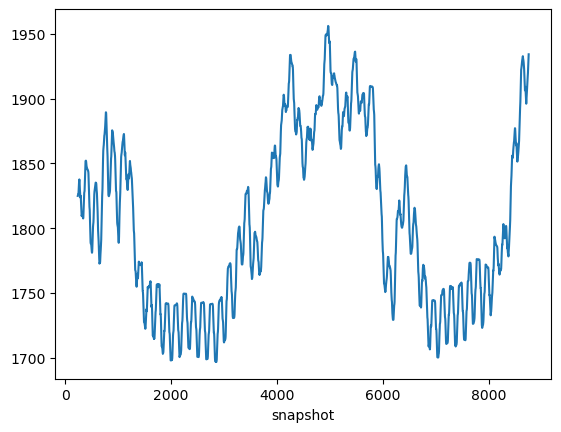

In [10]:
(network.generators_t.p["Wind"] + network.storage_units_t.p["Hydro"]).rolling(240).mean().plot()

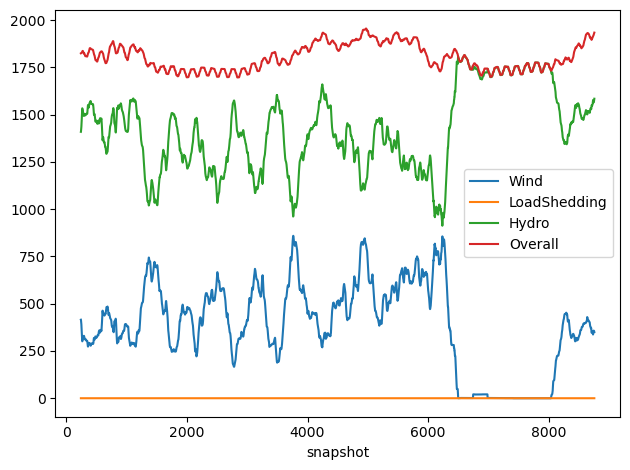

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
network.generators_t.p[["Wind", "LoadShedding"]].rolling(240).mean().plot(ax=ax)
network.storage_units_t.p.rolling(240).mean().plot(ax=ax)

# may be handy to check the balance
#(
#    network.generators_t.p["Wind"] + network.storage_units_t.p["Hydro"]
#).rolling(240).mean().plot()

network.loads_t.p_set["L1"].rolling(240).mean().plot(ax=ax)

plt.legend(["Wind", "LoadShedding", "Hydro", "Overall", "Load"], loc="best")
plt.tight_layout()

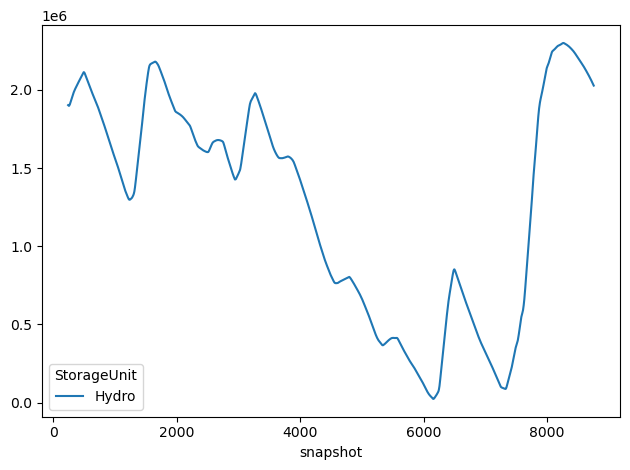

In [12]:
network.storage_units_t.state_of_charge.rolling(240).mean().plot()
plt.tight_layout()